#TEST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
file_path = '/content/drug200.csv'
data = pd.read_csv(file_path)

# Define categorical and numerical features based on actual data columns
categorical_features = ['Sex', 'BP', 'Cholesterol', 'Drug']
numerical_features = ['Age', 'Na_to_K']

# Create transformers for the pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations
data_preprocessed = preprocessor.fit_transform(data)

# Convert preprocessed data back to a DataFrame (optional, for visualization)
columns_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
new_columns = list(numerical_features) + list(columns_transformed)
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=new_columns)

# Print the first few rows of the preprocessed data
print(data_preprocessed_df.head())


        Age   Na_to_K  Sex_F  Sex_M  BP_HIGH  BP_LOW  BP_NORMAL  \
0 -1.291591  1.286522    1.0    0.0      1.0     0.0        0.0   
1  0.162699 -0.415145    0.0    1.0      0.0     1.0        0.0   
2  0.162699 -0.828558    0.0    1.0      0.0     1.0        0.0   
3 -0.988614 -1.149963    1.0    0.0      0.0     0.0        1.0   
4  1.011034  0.271794    1.0    0.0      0.0     1.0        0.0   

   Cholesterol_HIGH  Cholesterol_NORMAL  Drug_drugA  Drug_drugB  Drug_drugC  \
0               1.0                 0.0         0.0         0.0         0.0   
1               1.0                 0.0         0.0         0.0         1.0   
2               1.0                 0.0         0.0         0.0         1.0   
3               1.0                 0.0         0.0         0.0         0.0   
4               1.0                 0.0         0.0         0.0         0.0   

   Drug_drugX  Drug_drugY  
0         0.0         1.0  
1         0.0         0.0  
2         0.0         0.0  
3         

In [ ]:
# Load the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
data_preprocessed_df.head()

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug_drugA,Drug_drugB,Drug_drugC,Drug_drugX,Drug_drugY
0,-1.291591,1.286522,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.162699,-0.415145,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.162699,-0.828558,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.988614,-1.149963,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.011034,0.271794,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Define features and target
X = data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = data['Drug']

# Encode categorical features
X = pd.get_dummies(X, columns=['Sex', 'BP', 'Cholesterol'])

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


# Check the shapes of the splits
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (160, 9)
Testing features shape: (40, 9)
Training labels shape: (160,)
Testing labels shape: (40,)


# Model Implementation

**svm_with_smo**

In [ ]:
import numpy as np

# this library is used to show the progress of the training only
from tqdm import tqdm

def svm_with_smo(X, y, C, eps, max_iter, kernel):
    n_samples, n_features = X.shape

    # Initialize alpha to 0
    alpha = np.zeros(n_samples)

    # Initialize b to 0
    b = 0

    # Pre-compute the kernel matrix
    K = np.array([[kernel(X[i], X[j]) for j in range(n_samples)] for i in range(n_samples)])

    # Start iterations
    k = 0
    while k < max_iter:
        num_alpha_changed = 0
        for i in range(n_samples):
            Ei = b + np.sum(alpha * y * K[i]) - y[i]
            if (y[i] * Ei < -eps and alpha[i] < C) or (y[i] * Ei > eps and alpha[i] > 0):
                j = np.random.randint(0, n_samples)
                while j == i:
                    j = np.random.randint(0, n_samples)

                Ej = b + np.sum(alpha * y * K[j]) - y[j]
                alpha_old_i = alpha[i]
                alpha_old_j = alpha[j]

                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue

                alpha[j] -= y[j] * (Ei - Ej) / eta
                alpha[j] = np.clip(alpha[j], L, H)

                if abs(alpha[j] - alpha_old_j) < 0.00001:
                    continue

                alpha[i] += y[i] * y[j] * (alpha_old_j - alpha[j])

                b1_new_term = y[i] * (alpha[i] - alpha_old_i) * K[i, i]
                b2_new_term = y[j] * (alpha[j] - alpha_old_j) * K[j, j]
                b1 = b - Ei - b1_new_term - b2_new_term
                b2 = b - Ej - b1_new_term - b2_new_term

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_alpha_changed += 1

        if num_alpha_changed == 0:
            k += 1
        else:
            k = 0

    # Compute the weights
    w = np.sum(alpha * y * X.T, axis=1)

    return w, b





**One vs all classification**

In [ ]:
def one_versus_all(X, y, C, eps, kernel, max_iter):
    """
    Implementation of the one-versus-all strategy for multi-class classification.

    Args:
        train_X: The training data, shape (n_samples, n_features).
        train_y: The training labels, shape (n_samples,).
        C: The regularization strength.
        eps: The tolerance for stopping criterion.
        max_iter: The maximum number of iterations.

    Returns:
        W: The weights, shape (n_classes, n_features).
        b: The bias terms, shape (n_classes,).
    """

    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))

    # Initialize W and b
    W = np.zeros((n_classes, n_features))
    b = np.zeros(n_classes)

    # Train a binary classifier for each class
    for i in tqdm(range(n_classes)):
        # Create a copy of the labels
        y_train = np.copy(y)
        # Set all the labels to -1
        y_train[y_train != i] = -1
        # Set the labels of the current class to 1
        y_train[y_train == i] = 1

        # Train the binary classifier
        W[i], b[i] = svm_with_smo(X, y_train, C, eps, max_iter, kernel)

    return W, b

**One versus one classification**

In [ ]:

def one_versus_one(X, y, C, eps, kernel, max_iter):
    """
    Implementation of the one-versus-one strategy for multi-class classification.

    Args:
        X: The training data, shape (n_samples, n_features).
        y: The training labels, shape (n_samples,).
        C: The regularization strength.
        eps: The tolerance for stopping criterion.
        max_iter: The maximum number of iterations.
        kernel: The kernel function.

    Returns:
        W: The weights, shape (n_classes * (n_classes - 1) / 2, n_features).
        b: The bias terms, shape (n_classes * (n_classes - 1) / 2,).
    """

    n_samples, n_features = X.shape
    classes = np.unique(y)
    n_classes = len(classes)

    # Initialize W and b
    W = []
    b = []

    # Train a binary classifier for each pair of classes
    for i in tqdm(range(n_classes)):
        for j in range(i + 1, n_classes):
            # Create a binary label array
            binary_y = np.where((y == classes[i]) | (y == classes[j]), y, 0)
            binary_y = np.where(binary_y == classes[i], -1, binary_y)
            binary_y = np.where(binary_y == classes[j], 1, binary_y)

            # Exclude samples that don't belong to the i-th or j-th class
            binary_y_nonzero = binary_y[binary_y != 0]
            X_nonzero = X[binary_y != 0]

            # Train the binary classifier
            w, b_value = svm_with_smo(X_nonzero, binary_y_nonzero, C, eps, max_iter, kernel)

            W.append(w)
            b.append(b_value)

    return np.array(W), np.array(b)

**Predict functions**

In [ ]:
def predict_one_versus_all(X, W, b):
    # Calculate the scores for each classifier
    scores = np.dot(X, W.T) + b
    # The predicted class is the one with the highest score
    return np.argmax(scores, axis=1)
def predict_one_versus_one(X, W, b, classes):
    n_samples = X.shape[0]
    votes = np.zeros((n_samples, len(classes)))

    # Iterate over each classifier
    k = 0
    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):
            scores = np.dot(X, W[k]) + b[k]
            predictions = np.where(scores > 0, classes[j], classes[i])
            for p in range(n_samples):
                votes[p, predictions[p]] += 1
            k += 1

    # The predicted class is the one with the highest number of votes
    return np.argmax(votes, axis=1)


# Training in drug200 dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
file_path = '/content/drug200.csv'
data = pd.read_csv(file_path)

# Define features and target
X = data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
y = data['Drug']

# Encode categorical features
X = pd.get_dummies(X, columns=['Sex', 'BP', 'Cholesterol'])

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the kernel function
def kernel_linear(x1, x2):
    return np.dot(x1, x2)

100%|██████████| 5/5 [06:42<00:00, 80.55s/it]


One-vs-All Prediction Accuracy: 0.975
One-vs-All Prediction F1-Score: 0.9755305039787799
One-vs-All Prediction Recall: 0.975
One-vs-All Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 1  0  0  0 14]]
One-vs-All Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      0.93      0.97        15

    accuracy                           0.97        40
   macro avg       0.97      0.99      0.98        40
weighted avg       0.98      0.97      0.98        40

One-vs-One Prediction Accuracy: 0.925
One-vs-One Prediction F1-Score: 0.9286440570923331
One-vs-One Prediction Recall: 0.925
One-vs-One Confusion Matrix:
 [[ 5  1  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 10  0]
 [ 

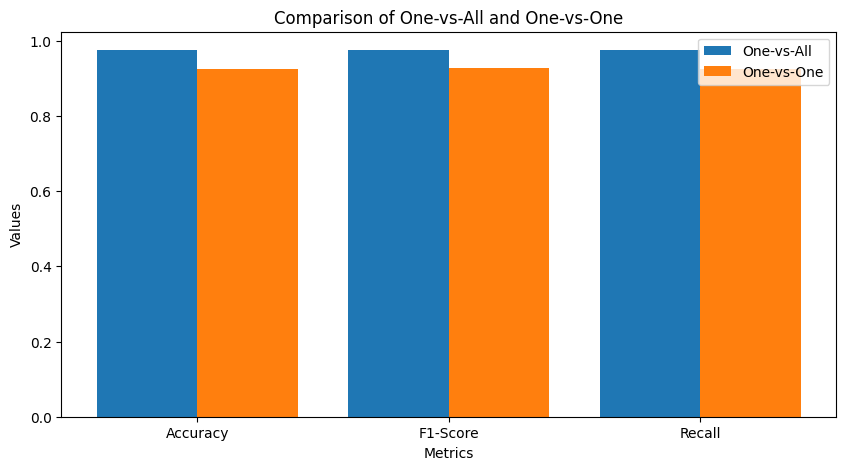

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train using one-versus-all on resampled data
W_one_all, b_one_all = one_versus_all(X_resampled, y_resampled, C=1.0, eps=0.001, kernel=kernel_linear, max_iter=1000)

# Train using one-versus-one on resampled data
W_one_one, b_one_one = one_versus_one(X_resampled, y_resampled, C=1.0, eps=0.001, kernel=kernel_linear, max_iter=1000)

# Predict using one-versus-all
y_pred_one_all = predict_one_versus_all(X_test, W_one_all, b_one_all)
accuracy_one_all = np.mean(y_pred_one_all == y_test)
f1_one_all = f1_score(y_test, y_pred_one_all, average='weighted')
recall_one_all = recall_score(y_test, y_pred_one_all, average='weighted')

print("One-vs-All Prediction Accuracy:", accuracy_one_all)
print("One-vs-All Prediction F1-Score:", f1_one_all)
print("One-vs-All Prediction Recall:", recall_one_all)
print("One-vs-All Confusion Matrix:\n", confusion_matrix(y_test, y_pred_one_all))
print("One-vs-All Classification Report:\n", classification_report(y_test, y_pred_one_all))

# Predict using one-versus-one
y_pred_one_one = predict_one_versus_one(X_test, W_one_one, b_one_one, np.unique(y_train))
accuracy_one_one = np.mean(y_pred_one_one == y_test)
f1_one_one = f1_score(y_test, y_pred_one_one, average='weighted')
recall_one_one = recall_score(y_test, y_pred_one_one, average='weighted')

print("One-vs-One Prediction Accuracy:", accuracy_one_one)
print("One-vs-One Prediction F1-Score:", f1_one_one)
print("One-vs-One Prediction Recall:", recall_one_one)
print("One-vs-One Confusion Matrix:\n", confusion_matrix(y_test, y_pred_one_one))
print("One-vs-One Classification Report:\n", classification_report(y_test, y_pred_one_one))

# Plotting metrics
metrics = ['Accuracy', 'F1-Score', 'Recall']
one_all_values = [accuracy_one_all, f1_one_all, recall_one_all]
one_one_values = [accuracy_one_one, f1_one_one, recall_one_one]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, one_all_values, 0.4, label='One-vs-All')
plt.bar(x + 0.2, one_one_values, 0.4, label='One-vs-One')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of One-vs-All and One-vs-One')
plt.xticks(x, metrics)
plt.legend()
plt.show()
